In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
map_path = "/private/home/arjunrs1/CliMer/scripts/gSAM_test_map.json"
keystep_test_path = "/private/home/arjunrs1/CliMer/data/egoexo4d/egoexo4d_exos_keysteps_test.csv"

with open(map_path, "rb") as f:
    gsam_map = json.load(f)

keystep_test = pd.read_csv(keystep_test_path)

In [3]:
keystep_test['SAM'] = keystep_test['clip_id'].map(gsam_map)
# Filter the DataFrame to only include rows where 'scalar' is not NaN
filtered_df = keystep_test[keystep_test['SAM'].notna()]

In [10]:
import pandas as pd
# Assuming df is your DataFrame and list_dicts is your list of dictionaries
results_path = "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/2024_09_03_05_05_init_iou_l1_egoexo4d_len64_e6d6_pos-learned_textpos-0_policy-default_bs16_lr0.0001_audio=False_decoder=True_keysteps=True_view=all_meandur=True_distill=False_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False/log/test_results_epoch_51.json"

# ego distill:
# "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/2024_08_27_16_29_init_iou_l1_egoexo4d_len64_e6d6_pos-learned_textpos-0_policy-default_bs16_lr0.0001_audio=False_decoder=True_keysteps=True_view=all_meandur=True_distill=False_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False/log/test_results_epoch_43.json"

# all-pairs distill:
# "/private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/2024_09_03_05_02_init_iou_l1_egoexo4d_len64_e6d6_pos-learned_textpos-0_policy-default_bs16_lr0.0001_audio=False_decoder=True_keysteps=True_view=all_meandur=True_distill=True_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False/log/test_results_epoch_50.json"

# all-pairs no distill:
# /private/home/arjunrs1/exo_narration_grounding/ExoGround/train/log/2024_09_03_05_05_init_iou_l1_egoexo4d_len64_e6d6_pos-learned_textpos-0_policy-default_bs16_lr0.0001_audio=False_decoder=True_keysteps=True_view=all_meandur=True_distill=False_pair_ds=False_pair_ds_mode=all_multi_ego=False_narr_rand=False/log/test_results_epoch_51.json

with open(results_path, "rb") as f:
    list_dicts = json.load(f)
df = filtered_df
# Initialize an empty list to store the tuples
result_tuples = []
scenario_dict = {}
total_samples = 0
# Iterate through each dictionary in the list
for data_dict in list_dicts:
    loss_values = data_dict['loss_dict']
    metadata = data_dict['metadata']
    narrations = metadata['narration']
    video_ids = metadata['video_id']
    cam_ids = metadata['cam_id']

    total_samples += len(loss_values)

    loss_index = 0
    # Flatten the list of narrations and associate each with a video_id and loss value
    for video_id, cam_id, narration_list in zip(video_ids, cam_ids, narrations):
        real_id = f"{video_id}_{cam_id}"
        scenario_name = real_id.split('_')[1]
        if scenario_name not in scenario_dict.keys():
            scenario_dict[scenario_name] = []
        for idx, narration in enumerate(narration_list):
            # Find the corresponding row in the DataFrame
            matched_rows_vid = df[df['narration'] == narration]
            matched_rows = matched_rows_vid[matched_rows_vid['video_id'] == real_id]
            if len(matched_rows) == 1:
                sam_value = matched_rows.iloc[0]['SAM'] #TODO: Need to fix this to not get multi rows
                loss_value = loss_values[loss_index]  # Assuming the index aligns with the loss_dict
                result_tuples.append((loss_value, sam_value))
                scenario_dict[scenario_name].append(loss_value)
            loss_index += 1
# result_tuples now contains the desired list of tuples
print(result_tuples)

[(0.06367944926023483, 1696909.0), (0.8086844682693481, 16211.0), (0.5656465888023376, 2877.0), (0.3467770516872406, 61264.0), (0.6687767505645752, 54139.0), (0.0, 1263733.0), (0.0, 599779.0), (0.49858126044273376, 694537.0), (0.6974033117294312, 6134721.0), (0.0, 6691488.0), (0.0, 6685590.0), (0.0, 11174.0), (0.0, 485526.0), (0.0, 35565.0), (0.0, 14531.0), (0.0, 1236840.0), (0.0, 1294776.0), (0.0, 23884.0), (0.447377473115921, 61652.0), (0.0, 49623.0), (0.0, 1374291.0), (0.004144077189266682, 1548970.0), (0.0, 1550897.0), (0.0196292195469141, 7854.0), (0.8575071692466736, 470790.0), (0.7864968776702881, 70992.0), (0.9502875208854675, 112302.0), (0.4273882508277893, 289276.0), (0.023613495752215385, 1528900.0), (0.0, 1330804.0), (0.0, 370603.0), (0.5393496155738831, 1265589.0), (0.6170772314071655, 874964.0), (0.8673745393753052, 2182987.0), (0.4210335910320282, 0.0), (0.8713755011558533, 2108102.0), (0.3181565999984741, 453806.0), (0.0, 184101.0), (0.6146506071090698, 402869.0), (0.96

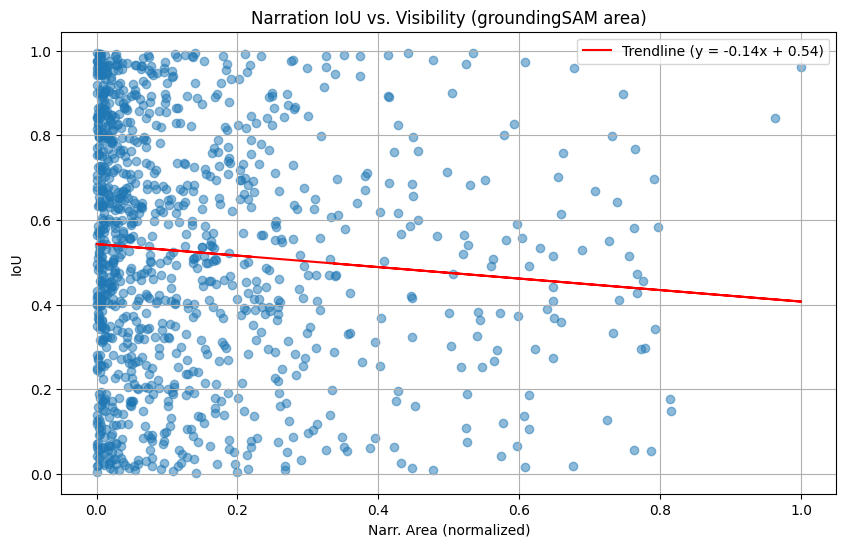

In [13]:
filtered_tuples = [t for t in result_tuples if t[0] != 0.0]
loss_values, sam_values = zip(*filtered_tuples)
# Normalize SAM values to be between 0 and 1
min_sam = min(sam_values)
max_sam = max(sam_values)
normalized_sam_values = [(sam - min_sam) / (max_sam - min_sam) for sam in sam_values]
# Convert lists to numpy arrays for linear regression
x = np.array(normalized_sam_values)
y = np.array(loss_values)
# Fit the linear regression
slope, intercept = np.polyfit(x, y, 1)
# Generate values for the trendline
trendline = slope * x + intercept
# Create a scatter plot with normalized SAM on the x-axis and loss on the y-axis
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.plot(x, trendline, color='red', label=f'Trendline (y = {slope:.2f}x + {intercept:.2f})')
plt.title('Narration IoU vs. Visibility (groundingSAM area)')
plt.xlabel('Narr. Area (normalized)')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()

cooking
1061
cpr
31
pcr
67
covid
304
bike
118


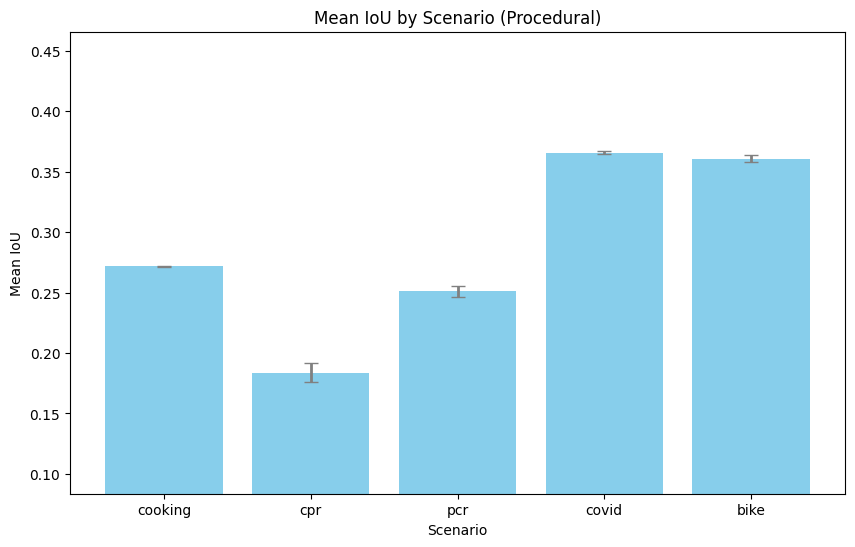

In [14]:
def normalize_scenario_name(name):
    if 'cooking' in name:
        return 'cooking'
    if 'covid' in name:
        return 'covid'
    return name
# Normalize and aggregate IoU values
normalized_dict = {}
for scenario, ious in scenario_dict.items():
    norm_scenario = normalize_scenario_name(scenario)
    if norm_scenario.isnumeric():  # Skip purely numeric scenario names
        continue
    if norm_scenario in normalized_dict:
        normalized_dict[norm_scenario].extend(ious)
    else:
        normalized_dict[norm_scenario] = ious.copy()
# Calculate the mean IoU and standard deviation for each normalized scenario
mean_iou = {}
std_dev = {}
for scenario, ious in normalized_dict.items():
    mean_iou[scenario] = np.mean(ious)
    std_dev[scenario] = np.std(ious) / len(ious)
    print(scenario)
    print(len(ious))
# Prepare data for plotting
scenarios = list(mean_iou.keys())
mean_ious = list(mean_iou.values())
errors = list(std_dev.values())
# Create a bar plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(scenarios, mean_ious, yerr=errors, capsize=5, color='skyblue', error_kw={'elinewidth': 2, 'ecolor': 'gray'})
plt.title('Mean IoU by Scenario (Procedural)')
plt.xlabel('Scenario')
plt.ylabel('Mean IoU')
plt.ylim([min(mean_ious) - 0.1, max(mean_ious) + 0.1])  # Adjust y-axis limits for better visualization
plt.show()

In [15]:
for key, val in scenario_dict.items():
    print(key)
    print(len(val))

cooking
1018
cpr
31
pcr
67
0711
293
covidtest
54
bike
118
covid
250
0702
54
cooking022
6
cooking028
37
